In [93]:
%load_ext autoreload
%autoreload 2

import plots
import runner
import analysis
import processing
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Replication of Meng et al. findings

Meng et al. setup for the 2 coupled network case:

* network with all-to-all coupling
* noisy-inputs to different neurons belonging to same or different network are uncorrelated
* IF neuron model
* input noise for a neuron is modeled as independent Poisson spike trains, mean rate is equal inside a network
* only inhibitory connections, gamma rhythm produced by ING mechanism
* local and global order parameter to measure synchrony

Observations
* with very weak noise: LFPs of different networks do not synchronize, they oscillate at different frequencies -> $r_{global}$ is small
* if noise increases at a certain point system jumps and global order parameter is significantly higher
* Reduction of noise leads now to increased desynchronization

Meng et al. main finding is that independent noise lead to synchronization across two networks

----

How can we replicate and extend with our current setup?

* two EI networks showing natural activity in gamma frequency band
* gamma produced by PING mechanism
* input noise also as Poisson Group per neuron
* compute local and global order parameter for one run
* parameter exploration with noise strength
* collect results and compare local and global order parameters
* generate plots for specific configurations as visual proof

## Model Configuration

In [102]:
# overwriting default parameters
params = {
  # synaptic coupling strengths, most important parameters for tuning PING mechanism
  "J_itoi": 20.0,
  "J_etoe": 2.,
  "J_etoi": 10.,
  "J_itoe": 6.,

  # Independent spike trains generated by Poisson Point Process for each target neuron
  "ext_input_type": "poisson",
  # in mV, influence of a pre synaptic spike
  # TODO: set it in the same ways as Meng et al. does it or argue why we should it differently
  "poisson_strengths": [.3, .3],
  # 50 Hz rate as in Meng et. al. and decreasing
  "poisson_rates": [50, 30],

  "J_ppee": 0.0,
  # increase from 0.1 to 0.2 increases mainly amplitude
  "J_ppei": 0.0,

  # if set to default of 0.1 this leads to strange split in frequency band
  "const_delay": 0.2,
  "N_pop": 2
}

pprint(params)

{'J_etoe': 2.0,
 'J_etoi': 10.0,
 'J_itoe': 6.0,
 'J_itoi': 20.0,
 'J_ppee': 0.0,
 'J_ppei': 0.0,
 'N_pop': 2,
 'const_delay': 0.2,
 'ext_input_type': 'poisson',
 'poisson_rates': [30, 30],
 'poisson_strengths': [0.3, 0.3]}


In [103]:
model = runner.run(modified_params=params, file_name="meng-replication")

Initializing net ...
initialization time: 51.40628719329834s
------------------ running network!
runtime: 19.3


In [96]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("meng-replication")


## Model Visualization

Generate PSD plot ...
Generate PSD plot ...


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131caa7f0>)

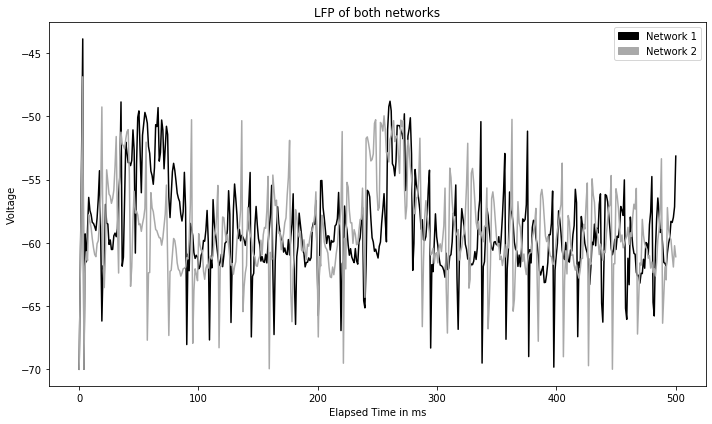

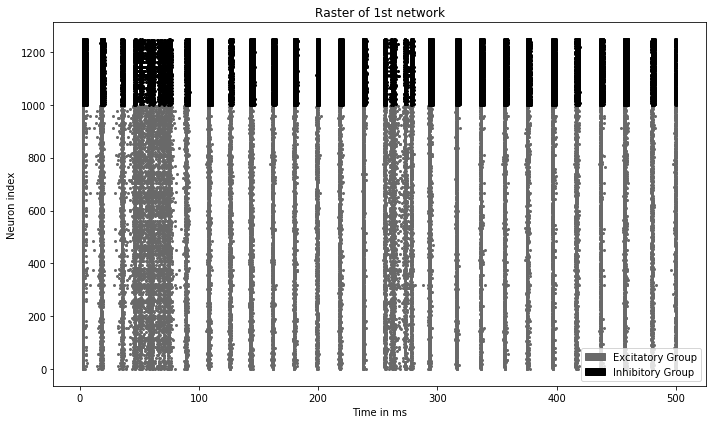

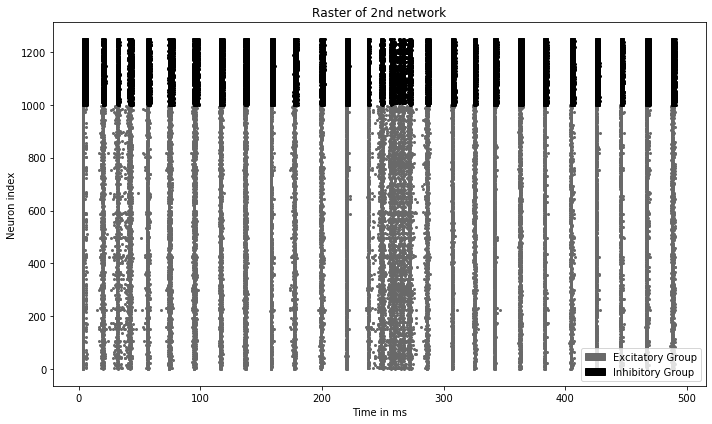

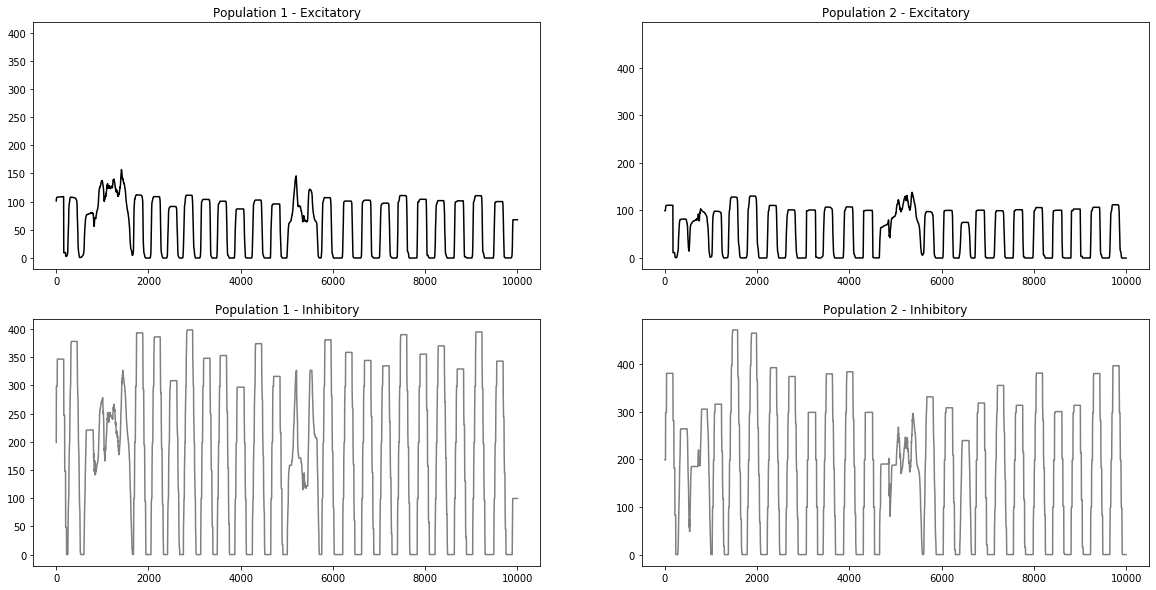

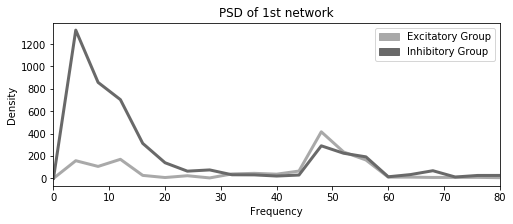

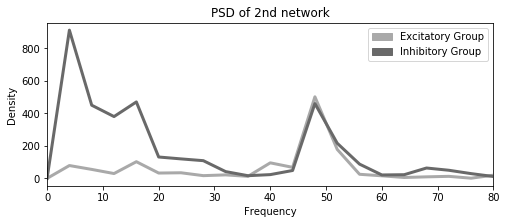

In [97]:
plots.lfp_nets(model)

plots.raster(title="Raster of 1st network", model=model)
plots.raster(title="Raster of 2nd network", model=model, population=2)

plots.population_rates(model)

plots.psd(model, title="PSD of 1st network")
plots.psd(model, title="PSD of 2nd network", population=2)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13208fe48>)

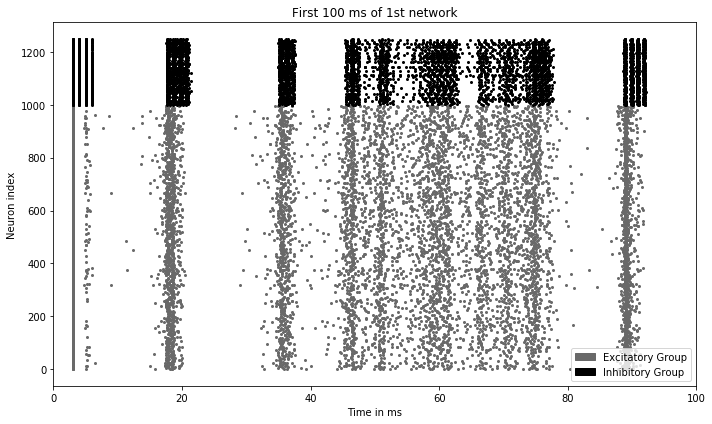

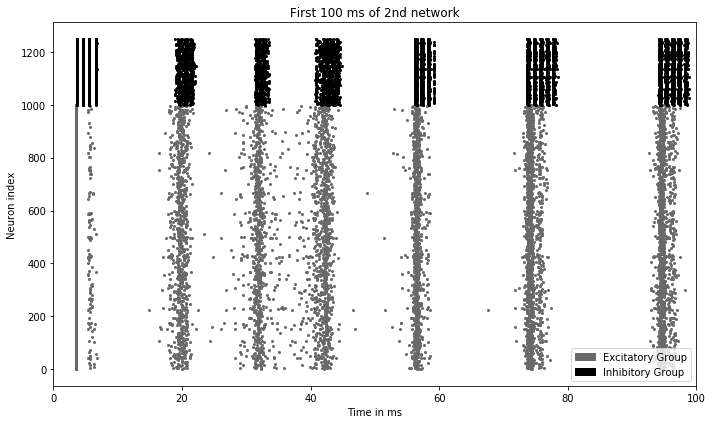

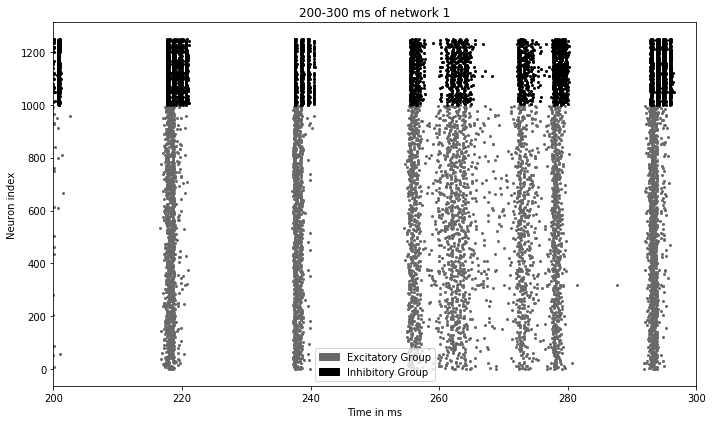

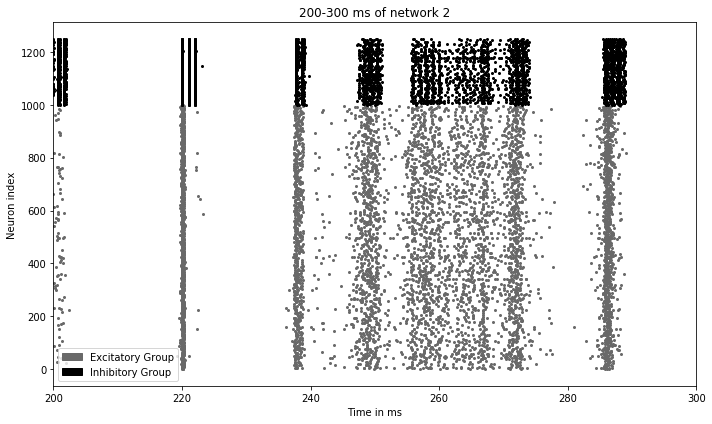

In [98]:
plots.raster(title="First 100 ms of 1st network", model=model, x_left=0, x_right=100)
plots.raster(title="First 100 ms of 2nd network", model=model, x_left=0, x_right=100, population=2)

plots.raster(title="200-300 ms of network 1", model=model, x_left=200, x_right=300)
plots.raster(title="200-300 ms of network 2", model=model, x_left=200, x_right=300, population=2)


## Synchronization Analysis

array([3.11247974, 3.29392508, 3.39571805, 2.98402992, 3.07133692,
       3.39999252, 3.00661257, 3.1882933 , 3.075373  , 3.20801797])
[178.33195305175948,
 177.80028233473874,
 175.4260937017846,
 177.742342438686,
 177.60509806954454,
 178.54771690961172,
 176.77108732608315,
 175.8752553046481,
 177.2032800653004,
 175.68150653151122]
Local order of 1.7135804617033896


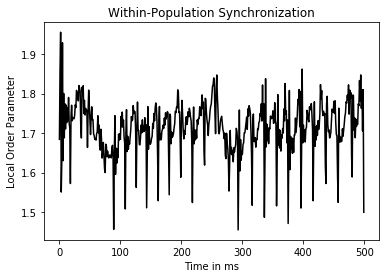

In [99]:
neurons_e = model['model_results']['net']['v_all_neurons_e']
neurons_i = model['model_results']['net']['v_all_neurons_i1']

phases = [processing.phase(neuron) for neuron in neurons_e]
phases.extend([processing.phase(neuron) for neuron in neurons_i])

pprint(phases[0][:10])
pprint([np.degrees(phase)[0] for phase in phases[:10]])

# average of each time step
avg_phase = np.average(phases, axis=0)

plt.title("Within-Population Synchronization")
plt.xlabel("Time in ms")
plt.ylabel("Local Order Parameter")
# plt.ylim(-2, 2)
plt.plot(avg_phase, c="black")

# TODO: we probably cannot simply take average of phase, have to convert it to complex representation and then average it?
print(f"Local order of {np.average(avg_phase)}")

In [100]:
plv_e = processing.phase_locking_value(neurons_e)
print(f"PLV of excitatory group {plv_e}")

plv_i = processing.phase_locking_value(neurons_i)
print(f"PLV of inhibitory group {plv_i}")

all_neurons = np.vstack((neurons_e, neurons_i))
plv_all = processing.phase_locking_value(all_neurons)
print(f"PLV of network 1 {plv_all}")


PLV of excitatory group 0.11130003795873472
PLV of inhibitory group 0.21298817468400003
PLV of network 1 0.09585519376601911


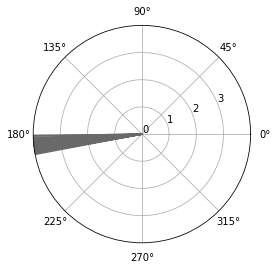

In [101]:
phases = [processing.phase(neuron) for neuron in neurons_e]

plt.axes(polar=True)
plt.ylim(0, 4)
plt.yticks(np.arange(0, 4 , 1.0))
for angle in phases:
    # TODO: calculate average across time for each neuron!

    # only angle matters, therefore we set constant radius
    plt.plot((0, angle[1]), (0, 4), c="dimgrey")
plt.show()